In [6]:
import pandas as pd
from google.cloud import bigquery
import numpy as np
import matplotlib.pyplot as plt
import math

In [7]:
new_output_df = pd.read_csv('research_papers_new_processing.csv', index_col=0)
bq_client = bigquery.Client(project='evident-data-dev')
old_output_df = bq_client.list_rows('evident-data-dev.curated_google_scholar.banking_research').to_dataframe()

qa_df = pd.read_csv('research_papers_qa_dataset.csv', index_col=0)


c:\Users\lucas\anaconda3\Lib\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
c:\Users\lucas\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
C:\Users\lucas\AppData\Local\Temp\ipykernel_27580\3503487757.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  qa_df = pd.read_csv('research_papers_qa_dataset.csv', index_col=0)


In [8]:
mask = ~old_output_df['paper_url'].isin(new_output_df['paper_url'])

old_not_new_df = old_output_df[mask]

old_not_new_df.drop_duplicates(subset=['paper_url'], inplace=True)

old_not_new_df.head()

C:\Users\lucas\AppData\Local\Temp\ipykernel_27580\4276207116.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_not_new_df.drop_duplicates(subset=['paper_url'], inplace=True)


,run_month,company_id,company_name,author_url,author_name,paper_url,paper_title,paper_date,paper_citations
10,2025-02-28,1002,Commerzbank,/citations?hl=en&user=TDAL0_EAAAAJ,Ludvík Tesař,/citations?view_op=view_citation&hl=en&user=TD...,gaussian mixture model for texture-based medic...,2015-01-01,0
25,2025-02-28,1003,Santander,/citations?hl=en&user=mZn3e8wAAAAJ,Jose M. Leiva Murillo,/citations?view_op=view_citation&hl=en&user=mZ...,algorithms for maximum-likelihood bandwidth,2015-01-01,0
39,2025-02-28,1004,JPMorganChase,/citations?hl=en&user=-NOTfHIAAAAJ,Sairamesh Konidala,/citations?view_op=view_citation&hl=en&user=-N...,training ai models on sensitive data-the feder...,2015-01-01,17
40,2025-02-28,1004,JPMorganChase,/citations?hl=en&user=-NOTfHIAAAAJ,Sairamesh Konidala,/citations?view_op=view_citation&hl=en&user=-N...,designing and implementing efficient data pipe...,2015-01-01,4
71,2025-02-28,1004,JPMorganChase,/citations?hl=en&user=1WkDG2UAAAAJ,Colin Targonski,/citations?view_op=view_citation&hl=en&user=1W...,a generalized deep learning approach for local...,2019-01-01,87


In [9]:
lhs_cols = ["company_name", "paper_url"]
rhs_cols = ["authors", 'url', "title", "publication_date", "is_patent", "tags",
            "excluded_tags", "keyword_tags", "has_publication_info"]

banks_with_qa = pd.merge(
    old_not_new_df[lhs_cols],
    qa_df[rhs_cols],
    left_on='paper_url',
    right_on = 'url',
    how='left').drop(columns=['url'])

banks_with_qa = banks_with_qa.replace("[]", np.nan)

def get_exclusion_reason(row):

    reasons = []

    if row['is_patent'] == True:
        reasons.append("is_patent")

    if pd.notna(row['excluded_tags']):
        reasons.append("excluded_tags")

    if pd.isna(row['tags']):
        reasons.append("no_tags")

    if pd.isna(row['authors']):
        reasons.append("no_authors")

    if pd.isna(row['publication_date']):
        reasons.append("no_publication_date")

    return reasons

exclusion_reasons_df = pd.DataFrame(columns=['company_name', 'exclusion_reason', 'count'])

banks_with_qa['exclusion_reason'] = banks_with_qa.apply(get_exclusion_reason, axis=1)

banks_with_qa.drop_duplicates(subset=['paper_url'], inplace=True)

exclusion_reasons_df = banks_with_qa.explode('exclusion_reason')

exclusion_reasons_df = exclusion_reasons_df.groupby(['company_name', 'exclusion_reason']).size().reset_index(name='count')

exclusion_reasons_df

,company_name,exclusion_reason,count
0,ABN AMRO,no_publication_date,3
1,ANZ,no_publication_date,1
2,BBVA,excluded_tags,1
3,BBVA,no_publication_date,2
4,BBVA,no_tags,6
...,...,...,...
85,Wells Fargo,excluded_tags,4
86,Wells Fargo,no_authors,1
87,Wells Fargo,no_publication_date,8
88,Wells Fargo,no_tags,3


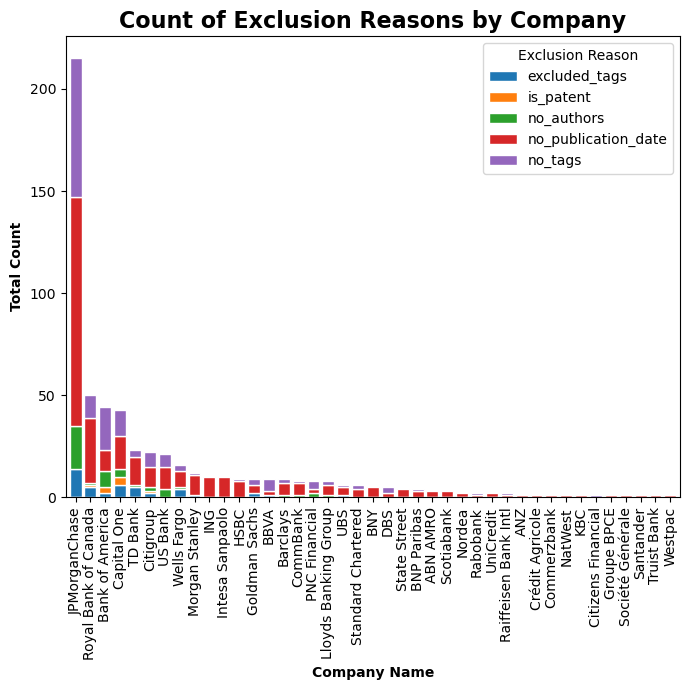

In [ ]:
pivoted_df = exclusion_reasons_df.pivot(
    index='company_name',
    columns='exclusion_reason',
    values='count'
).fillna(0)

pivoted_df['total'] = pivoted_df.sum(axis=1)

pivoted_df.sort_values(by='total', ascending=False,inplace=True)

# pivoted_df.drop("JPMorganChase", inplace=True)

ax = pivoted_df.drop(columns="total").plot(
    kind='bar',
    stacked=True,
    figsize=(7, 7),
    edgecolor='white',
    width=0.8   
)

plt.title('Count of Exclusion Reasons by Company', fontsize=16, fontweight='bold')
plt.xlabel('Company Name', fontweight='bold')
plt.ylabel('Total Count', fontweight='bold')
plt.legend(title='Exclusion Reason')
plt.tight_layout()
plt.show()

In [ ]:
pivoted_df.to_excel("excluded_counts.xlsx")

exclusion_reason,excluded_tags,is_patent,no_authors,no_publication_date,no_tags,total
company_name,,,,,,
JPMorganChase,14.0,0.0,21.0,112.0,68.0,215.0
Royal Bank of Canada,5.0,1.0,1.0,32.0,11.0,50.0
Bank of America,2.0,3.0,8.0,10.0,21.0,44.0
Capital One,6.0,4.0,4.0,16.0,13.0,43.0
TD Bank,5.0,0.0,1.0,14.0,3.0,23.0
Citigroup,2.0,1.0,2.0,10.0,7.0,22.0
US Bank,0.0,0.0,4.0,11.0,6.0,21.0
Wells Fargo,4.0,0.0,1.0,8.0,3.0,16.0
Morgan Stanley,1.0,0.0,0.0,10.0,1.0,12.0
